In [58]:
import os
import pandas as pd
import json
from glob import glob
from tqdm import tqdm
import obspy
import obspy.taup
import warnings
warnings.filterwarnings("ignore")

In [59]:
os.system("curl -L -O https://github.com/AI4EPS/EPS207_Observational_Seismology/releases/download/fm_data/fm_data.zip && unzip -q -o fm_data.zip")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3137k  100 3137k    0     0  5046k      0 --:--:-- --:--:-- --:--:-- 5046k


0

In [60]:
data_path = 'fm_data'
with open(f"{data_path}/stations.json", "r") as f:
    stations = json.load(f)

stations = pd.DataFrame.from_dict(stations, orient='index')
stations["station_id"] = stations.index
events = pd.read_csv(f"{data_path}/catalog.csv", parse_dates=['time'])
events['time'] = events['time'].dt.tz_localize(None)
if "event_id" in events.columns:
    events.rename(columns={"event_id": "event_index"}, inplace=True)
events.set_index('event_index', inplace=True)

picks = pd.read_csv(f"{data_path}/picks.csv", parse_dates=['phase_time'])

# merge picks and events based on event_index
picks = picks.merge(events, on="event_index", suffixes=("_pick", "_event"))
picks = picks.merge(stations, on="station_id", suffixes=("_pick", "_station"))

In [61]:
events[:3]

,time,magnitude,latitude,longitude,depth_km,agency,x_km,y_km,z_km
event_index,,,,,,,,,
ci38443095,2019-07-04 17:02:55.340,3.98,35.70817,-117.50367,10.60,ci,0.030,0.351,10.60
ci38443111,2019-07-04 17:09:20.090,2.49,35.70767,-117.50133,10.97,ci,0.241,0.296,10.97
ci38443119,2019-07-04 17:11:32.850,0.63,35.70550,-117.49750,11.20,ci,0.588,0.055,11.20


In [62]:
picks[:3]

,station_id,phase_index,phase_time,phase_score,phase_type,phase_polarity,phase_amplitude,event_index,time,magnitude,...,component,sensitivity,latitude_station,longitude_station,elevation_m,depth_km_station,x_km_station,y_km_station,z_km_station,provider
0,CI.CLC..BH,3042,2019-07-04 17:51:49.778,0.499,P,-0.660,0.000235,ci38443287,2019-07-04 17:51:46.650,3.46,...,ENZ,"[627373000.0, 627373000.0, 627373000.0]",35.81574,-117.59751,775.0,-0.775,-8.451,12.291,-0.775,SCEDC
1,CI.CLC..BH,3297,2019-07-04 17:51:52.328,0.904,S,0.001,0.000551,ci38443287,2019-07-04 17:51:46.650,3.46,...,ENZ,"[627373000.0, 627373000.0, 627373000.0]",35.81574,-117.59751,775.0,-0.775,-8.451,12.291,-0.775,SCEDC
2,CI.CLC..BH,2997,2019-07-04 17:40:48.314,0.801,P,-0.779,0.000212,ci37222516,2019-07-04 17:40:46.140,3.42,...,ENZ,"[627373000.0, 627373000.0, 627373000.0]",35.81574,-117.59751,775.0,-0.775,-8.451,12.291,-0.775,SCEDC


### 1. Stations and Events

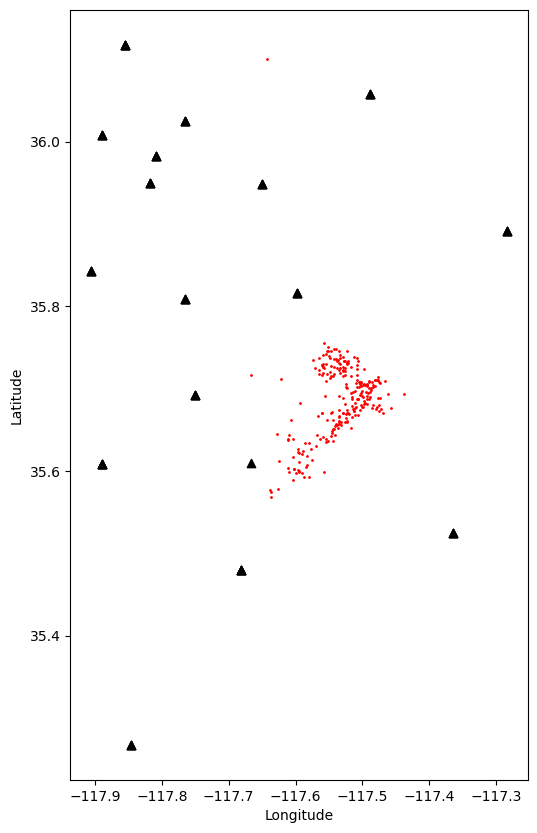

In [63]:
plt.figure(figsize=(10, 10))
plt.scatter(stations['longitude'], stations['latitude'], color='k', marker='^')
plt.scatter(events['longitude'], events['latitude'], s=1, color='r', marker='o')
plt.gca().set_aspect(1.0/np.cos(np.pi/180*stations['latitude'].mean()))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### 2. Convert the station list format

In [64]:
hash_path = "hashpy2_input"
if not os.path.exists(hash_path):
    os.makedirs(hash_path)

In [65]:
# "LOCSRCE station LATLON latitude longitdue depth elevation"
station_fmt = "LOCSRCE {} LATLON {} {} 0 {}\n"
# the file containing station information
stafile = f'./{hash_path}/stations.nll'
with open(stafile,'w') as fp:
    for _, station in stations.iterrows():
        fp.writelines(station_fmt.format(station['station_id'], station['latitude'], station['longitude'], station['elevation_m']/1000))
    # for i in df_stations.index:
    #     if df_stations.loc[i, 'component'] != 'Z':
    #         continue
    #     network = df_stations.loc[i,'network']
    #     station = df_stations.loc[i,'station']
    #     instrument = df_stations.loc[i,'instrument']
    #     longitude = df_stations.loc[i,'longitude']
    #     latitude = df_stations.loc[i,'latitude']
    #     elevation = df_stations.loc[i,'elevation_m']/1000
    #     sn.writelines(station_fmt.format('.'.join([network,station,'',instrument]), latitude, longitude, elevation))

In [66]:
!head ./hashpy2_input/stations.nll

LOCSRCE CI.CCC..BH LATLON 35.52495 -117.36453 0 0.67
LOCSRCE CI.CCC..HH LATLON 35.52495 -117.36453 0 0.67
LOCSRCE CI.CCC..HN LATLON 35.52495 -117.36453 0 0.67
LOCSRCE CI.CLC..BH LATLON 35.81574 -117.59751 0 0.775
LOCSRCE CI.CLC..HH LATLON 35.81574 -117.59751 0 0.775
LOCSRCE CI.CLC..HN LATLON 35.81574 -117.59751 0 0.775
LOCSRCE CI.DTP..BH LATLON 35.26742 -117.84581 0 0.908
LOCSRCE CI.DTP..HH LATLON 35.26742 -117.84581 0 0.908
LOCSRCE CI.DTP..HN LATLON 35.26742 -117.84581 0 0.908
LOCSRCE CI.JRC2..BH LATLON 35.98249 -117.80885 0 1.469


In [67]:
picks_by_event

# 3. Create polarity and S/P data file

In [70]:
# year month day hour minute seconds evla evlo evdp errh errz evid
eventlinefmt = "{:04d} {:02d} {:02d} {:02d} {:02d} {:05.2f} {:010.6f} {:010.6f} {:09.6f} {:05.2f} {:05.2f} {:}\n"
# station polarity "qp" S/P_ratio
stationlinefmt = "{} {:1s} 0 {:08.3f}\n"
# for pickfile in pickfiles:

picks_by_event = picks.groupby("event_index")

# for _, pick in tqdm(picks.iterrows(), total=len(picks)):

for event_index, picks_ in tqdm(picks_by_event):
    # the file being created which should contain event information, polarity and S/P data
    polfile = f'{hash_path}/{event_index}.pol.hash'
    # pf = open(polfile, 'w')
    # # write event information into the file
    # event_id = os.path.basename(pickfile).split('.')[0]
    # _, evot, mag, evla, evlo, evdp, x, y, z = df_events[df_events['event_id'] == event_id].to_numpy()[0]
    # evot = UTCDateTime(evot)
    # pf.writelines(eventlinefmt.format(evot.year,evot.month,evot.day,evot.hour,evot.minute,\
    #                                       evot.second+1e-6*evot.microsecond,evla,evlo,evdp,0.0,0.0,event_id))

    event_info = events.loc[event_index]
    with open(polfile, 'w') as pf:
        # write event information into the file
        pf.writelines(eventlinefmt.format(event_info['time'].year, event_info['time'].month, event_info['time'].day, event_info['time'].hour, event_info['time'].minute, event_info['time'].second+1e-6*event_info['time'].microsecond, event_info['latitude'], event_info['longitude'], event_info['depth_km'], 0.0, 0.0, event_index))

        # loop for all station that have picks
        # if no P pick, continue the next loop
        # if P pick exists and its polarity prob exceeds a certain value
        # assign 'U','u','+' or 'D','d','-', respectively, otherwise 'x'
        # if both P and S picks exist, divide S by P amplitude as S/P ratio
        # if no S pick, set the ratio to zero
        picks_by_station = picks_.groupby("station_id")
        for station_id, picks__ in picks_by_station:
            if 'P' not in picks__['phase_type'].values:
                continue
            P_polarity = picks__[picks__['phase_type'] == 'P']['phase_polarity'].values[0]
            if P_polarity < -0.3:
                polarity = '-'
            elif P_polarity > 0.3:
                polarity = '+'
            else:
                polarity = 'x'
            if 'S' in picks__['phase_type'].values:
                S_polarity = picks__[picks__['phase_type'] == 'S']['phase_polarity'].values[0]
                S_amplitdue = picks__[picks__['phase_type'] == 'S']['phase_amplitude'].values[0]
                P_amplitdue = picks__[picks__['phase_type'] == 'P']['phase_amplitude'].values[0]
                SP_ratio = S_amplitdue/P_amplitdue
            else:
                SP_ratio = 0
            # write polarity and S/P ratio data at each station into the file
            pf.writelines(stationlinefmt.format(station_id, polarity, SP_ratio))

    # # get P and/or S pick polarity and amplitude for each station
    # df_picks = pd.read_csv(pickfile)
    # dict_picks = {}
    # for i in df_picks.index:
    #     station_id = df_picks.loc[i, 'station_id']
    #     if station_id not in dict_picks:
    #         dict_picks[station_id] = {}
    #     if df_picks.loc[i, 'phase_type'] not in dict_picks[station_id]:
    #         dict_picks[station_id][df_picks.loc[i, 'phase_type']] = [df_picks.loc[i, 'phase_polarity'], df_picks.loc[i, 'phase_amplitude']]

    # for station_id in dict_picks:
    #     if 'P' in dict_picks[station_id]:
    #         P_polarity, P_amplitdue = dict_picks[station_id]['P']
    #         if P_polarity < -0.3:
    #             polarity = '-'
    #         elif P_polarity > 0.3:
    #             polarity = '+'
    #         else:
    #             polarity = 'x'
    #         if 'S' in dict_picks[station_id]:
    #             S_polarity, S_amplitdue = dict_picks[station_id]['S']
    #             SP_ratio = S_amplitdue/P_amplitdue
    #         else:
    #             SP_ratio = 0
    #     else:
    #         continue
    #     # write polarity and S/P ratio data at each station into the file
    #     pf.writelines(stationlinefmt.format(station_id, polarity, SP_ratio))
    # pf.close()

100%|██████████| 251/251 [00:03<00:00, 75.02it/s] 


In [71]:
!head ./hashpy2_input/ci37230908.pol.hash

2019 07 04 18 57 42.06 035.713330 -117.548170 02.020000 00.00 00.00 ci37230908
CI.CCC..BH + 0 0001.686
CI.CCC..HH + 0 0001.780
CI.CCC..HN + 0 0002.448
CI.CLC..BH - 0 0001.000
CI.CLC..HH - 0 0001.000
CI.CLC..HN - 0 0001.821
CI.DTP..HH - 0 0000.000
CI.DTP..HN x 0 0000.000
CI.JRC2..BH x 0 0001.155


# 4. Prepare input files for the HASH command

In [74]:
velocity_model = """0.00  4.74000
1.00  5.01000
2.00  5.35000
3.00  5.71000
4.00  6.07000
5.00  6.17000
6.00  6.27000
7.00  6.34000
8.00  6.39000
30.00 7.80000
"""
with open(f'{hash_path}/ca.vel', 'w') as fp:
    fp.writelines(velocity_model)

# loop for all polarity data files
polfiles = glob(f'{hash_path}/ci*.pol.hash')
for polfile in tqdm(list(polfiles)):
    event_id = os.path.basename(polfile).split('.')[0]
    # the inputfile which should contain input and output files and parameters
    iptfile = f'{hash_path}/{event_id}.inp.hash'
    # the file containing the best solutions
    optfile1 = f'{hash_path}/{event_id}.best.fps'
    # the file containing all solutions
    optfile2 = f'{hash_path}/{event_id}.all.fps'
    # the file containing ray parameters
    optfile3 = f'{hash_path}/{event_id}.rays'
    # the file containing velocity profile
    velfile = f'{hash_path}/ca.vel'
    # Angle increment for grid search
    dang = 1
    # Number of perutbations of take-off angles for different source depths and velocity models
    nmc = 50
    # Maximum number focal mechanisms that match misfit critria to return
    maxout = 20
    # maximum distance to consider (km)
    maxdist = 100
    # number of polarities assumed bad
    nbadpol = 4
    # log10 of uncertainty factor for s/p ratios.
    qbadfac = 0.2
    # Angular distance between different families of focal mechanisms.
    cangle = 45
    # Fraction of focal mechanisms that need to be within cangle to make up a new famlily of focal mechanisms.
    prob_max = 0.2
    # number of velocity models
    nvelmod = 1
    # write these information sequencially into the inputfile
    with open(iptfile, 'w') as ipt:
        ipt.writelines('{}\n{}\n{}\n{}\n{}\n'.format(polfile,stafile,optfile1,optfile2,optfile3))
        ipt.writelines('{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n'.format(dang,nmc,maxout,maxdist,nbadpol,qbadfac,cangle,prob_max))
        ipt.writelines('{}\n{}\n'.format(nvelmod, velfile))
    # run the command
    os.system('QuakeFlow/hashpy2/hash/hash_hashpy1D < %s'%iptfile)

  0%|          | 0/251 [00:00<?, ?it/s]sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary file
sh: QuakeFlow/hashpy2/hash/hash_hashpy1D: cannot execute binary 

# 5. Plot result of a single event

In [12]:
event_id = 'ci38443743'

In [13]:
allmecafile = f'{hash_path}/{event_id}.all.fps'
df_allmeca = pd.read_csv(allmecafile, header=None, delim_whitespace=True)
df_allmeca

,0,1,2,3,4,5,6,7,8
0,137.0,40.0,165.0,0.43874,0.46977,0.76604,-0.84126,0.51439,0.16637
1,139.4,45.0,180.0,0.46006,0.53698,0.70711,-0.75940,0.65062,0.00000
2,139.4,45.0,175.0,0.46006,0.53698,0.70711,-0.79661,0.60134,0.06163
3,139.4,45.0,170.0,0.46006,0.53698,0.70711,-0.82776,0.54749,0.12279
4,139.4,45.0,165.0,0.46006,0.53698,0.70711,-0.85260,0.48947,0.18301


In [14]:
bestmecafile= f'{hash_path}/{event_id}.best.fps'
df_bestmeca= pd.read_csv(bestmecafile, header=None, delim_whitespace=True)
df_bestmeca

,0,1,2,3,4
0,139,44,171,4,A


NameError: name 'df_bestmeca' is not defined

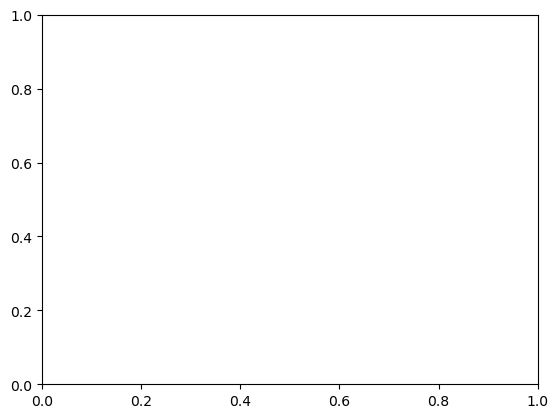

In [75]:
from obspy.imaging.beachball import beach
fig, ax = plt.subplots()
# plot the best one first
strike, dip, rake = df_bestmeca.loc[0].to_numpy()[:3]
bball = beach(fm=[strike, dip, rake],facecolor='k', xy=(0,0), width=100)
ax.add_collection(bball)
# plot all solutions that meet the criterion
for i in df_allmeca.index:
    strike, dip, rake = df_allmeca.loc[i].to_numpy()[:3]
    bball = beach(fm=[strike, dip, rake], linewidth=1, nofill=True, xy=(0,0), width=100, edgecolor='gray', alpha=0.5)
    ax.add_collection(bball)
plt.xlim(-50, 50)
plt.ylim(-50, 50)
ax.set_aspect('equal')
fig.tight_layout()

# 6. Plot focal mechanisms of earthquakes

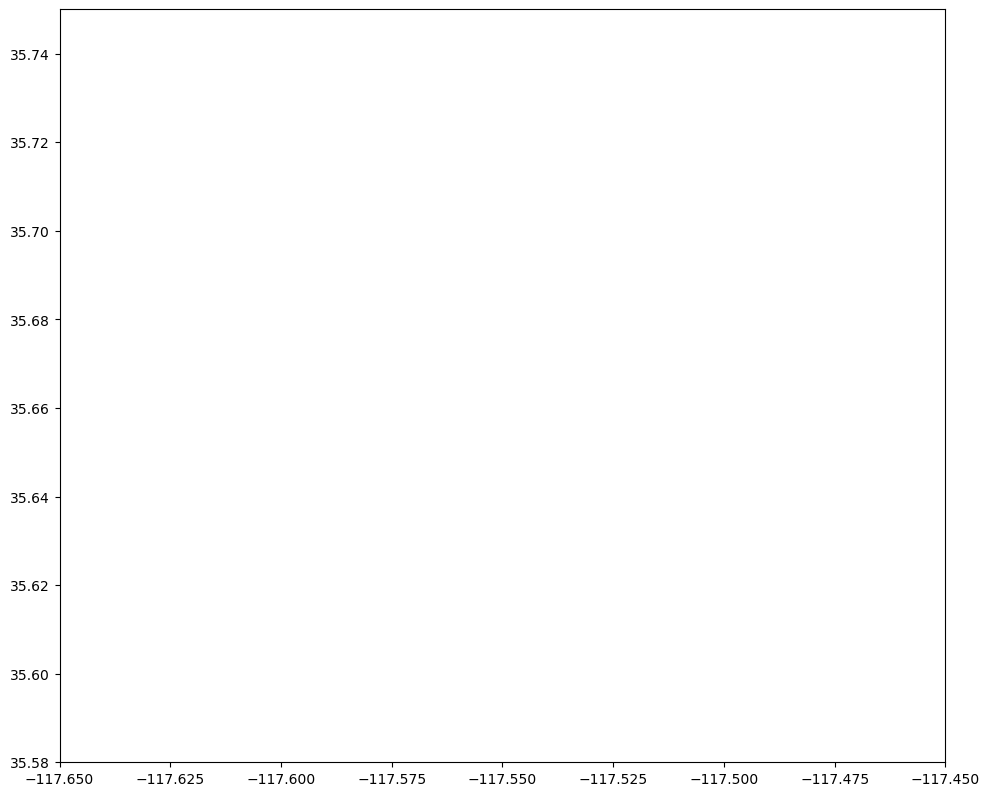

In [77]:
bestmecafiles = glob(f'{hash_path}/ci*.best.fps')
fig, ax = plt.subplots(figsize=(10, 10))
for bestmecafile in bestmecafiles:
    # get the event information
    event_id = os.path.basename(bestmecafile).split('.')[0]
    _, evot, mag, evla, evlo, evdp, x, y, z = df_events[df_events['event_id'] == event_id].to_numpy()[0]
    evot = UTCDateTime(evot)
    # get strike, dip and rake angles
    df_bestmeca= pd.read_csv(bestmecafile, header=None, delim_whitespace=True)
    strike, dip, rake, RMS, Q = df_bestmeca.loc[0].to_numpy()
    # plot and change the width/size according to the earthquake magnitude
    bball = beach(fm=[strike, dip, rake], linewidth=0.5, facecolor='k', xy=(evlo,evla), width=mag*2e-3)
    ax.add_collection(bball)
    ax.annotate(Q, (evlo,evla), (evlo+0.02,evla), arrowprops=dict(facecolor='black', width=0.05, headwidth=0.05))
ax.set_xlim(-117.65, -117.45)
ax.set_ylim(35.58, 35.75)
ax.set_aspect('equal')
fig.tight_layout()